In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import os.path as osp

In [2]:
file = osp.join('.', 'Videos',
                'Traffic IP Camera video.mp4')
cap = cv.VideoCapture(file)

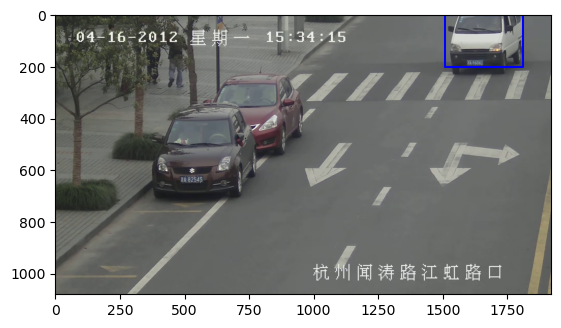

In [3]:
# frame with target
cap.set(cv.CAP_PROP_POS_FRAMES, 90)
_, frame = cap.read()
target = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
#Display the resulting frame
plt.imshow(target)

# setup initial location of window
init_x, init_y, w, h = 1510, 0, 300, 200
plt.plot([init_x, init_x + w, init_x + w, init_x, init_x],
         [init_y, init_y, init_y + h, init_y + h, init_y], 'b-')

In [4]:
# # take first frame of the video
# ret,frame = cap.read()

track_window = (init_x, init_y, w, h)

# set up the Region-Of-Interest for tracking
roi = frame[init_y:init_y+h, init_x:init_x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)
pass

In [5]:
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
count = 120
iter_count = 1
frame_len = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) - count

prev_win = track_window
reset_iter = 0
frames = []

end = count + frame_len
while (count := count + iter_count) < end:
    cap.set(cv.CAP_PROP_POS_FRAMES, count)
    ret, frame = cap.read()
    if ret:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # apply meanshift to get the new location
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # Draw it on image
        x, y, w, h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        # plt.figure()
        # plt.imshow(img2)
        frames.append(img2)
        if abs(prev_win[0] - x + prev_win[1] - y) <= 3:
            reset_iter += 1
            if reset_iter > 20:
                track_window = (init_x, init_y, w, h)
                reset_iter = 0
        else: reset_iter = 0
        prev_win = track_window
    else: break

In [18]:
fourcc = cv.VideoWriter_fourcc(*'DIVX')
out = cv.VideoWriter(osp.join('.', 'Output', 'output.avi'), fourcc, 20.0, (1920,  1080))
for temp in frames:
    out.write(temp)
out.release()

In [5]:
import os.path as osp
import cv2 as cv
import numpy as np

# Set the correct paths to your downloaded files in the 'yolo' folder
weights_path = osp.join('yolo', 'yolov3.weights')
config_path = osp.join('yolo', 'yolov3.cfg')
names_path = osp.join('yolo', 'coco.names')

# Load YOLO object detection model
net = cv.dnn.readNet(weights_path, config_path)

# Get the names of the output layers
layer_names = net.getLayerNames()
unconnected_out_layers = net.getUnconnectedOutLayers()

# Adjust the indexing based on whether the output is an array or a scalar
if isinstance(unconnected_out_layers, np.ndarray):
    unconnected_out_layers = unconnected_out_layers.flatten()

output_layers = [layer_names[i - 1] for i in unconnected_out_layers]

# Load COCO classes (for car detection)
with open(names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Video capture from your input video
cap = cv.VideoCapture('Videos/Traffic IP Camera video.mp4')

# Get the width and height of the video frames
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

# Initialize the MultiTracker using legacy API
trackers = cv.legacy.MultiTracker_create()

frame_count = 0
detection_interval = 30  # Perform object detection every 30 frames

frames = []  # List to hold frames for output

# Function to run YOLO detection
def detect_objects(frame):
    height, width = frame.shape[:2]
    blob = cv.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Focus on cars (class ID of 'car' in COCO is usually 2)
            if confidence > 0.5 and classes[class_id] == 'car':
                # Object detected
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                w = int(obj[2] * width)
                h = int(obj[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Perform detection at every detection_interval frames
    if frame_count % detection_interval == 0 or len(trackers.getObjects()) == 0:
        # Detect cars in the current frame
        boxes = detect_objects(frame)

        # Reinitialize the tracker every detection interval
        trackers = cv.legacy.MultiTracker_create()

        for box in boxes:
            x, y, w, h = box
            tracker = cv.legacy.TrackerCSRT_create()  # You can use other trackers like KCF or MedianFlow
            trackers.add(tracker, frame, (x, y, w, h))

    # Update the trackers for every frame
    success, tracked_boxes = trackers.update(frame)

    # Draw the tracking boxes
    for box in tracked_boxes:
        x, y, w, h = [int(v) for v in box]
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Append the current frame to the frames list
    frames.append(frame)

# Release the VideoCapture object
cap.release()

# At this point, the `frames` list contains all the processed frames
print("Frames collected for video output.")


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\darknet\darknet_importer.cpp:207: error: (-212:Parsing error) Failed to parse NetParameter file: yolo\yolov3.cfg in function 'cv::dnn::dnn4_v20211220::readNetFromDarknet'


In [ ]:
import os.path as osp
import cv2 as cv

# VideoWriter setup (no need to create folder since it already exists)
fourcc = cv.VideoWriter_fourcc(*'DIVX')
output_path = osp.join('Output', 'output.avi')
out = cv.VideoWriter(output_path, fourcc, 20.0, (1920, 1080))

# Assuming 'frames' is a list of frames you want to write into the video
for temp in frames:
    out.write(temp)

# Release the VideoWriter object
out.release()

print(f"Output video saved to {output_path}")

In [1]:
import cv2 as cv
import numpy as np

print("OpenCV version:", cv.__version__)
print("NumPy version:", np.__version__)

OpenCV version: 4.5.5
NumPy version: 1.21.6
